In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform

In [2]:
df = pd.read_csv("data3.csv")
df

,p1,p2,p3,p4
0,3.745401,1.727030,9.723854,-0.699337
1,9.507143,2.966814,2.585795,-0.891283
2,7.319939,-2.495321,13.085918,-0.049140
3,5.986585,1.248741,9.196744,1.550008
4,1.560186,0.717460,2.358058,0.920662
...,...,...,...,...
2995,8.652958,1.844354,7.723942,0.053968
2996,1.572732,0.032204,2.480556,0.982780
2997,3.097879,2.651488,14.665692,-0.287439
2998,2.900455,-0.147094,1.618868,-0.224556


In [3]:
df.describe()

,p1,p2,p3,p4
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,4.998932,-0.056850,7.310881,-0.016117
std,2.916564,2.874237,4.283771,0.839563
min,0.000116,-4.999693,0.003615,-1.981106
25%,2.458056,-2.542724,3.622006,-0.673189
50%,5.053537,-0.119611,7.236875,0.016096
75%,7.543344,2.385903,10.930185,0.648512
max,9.997177,4.995577,14.991910,2.034798


In [4]:
x, y = df[["p1", "p2", "p4"]], df["p3"]

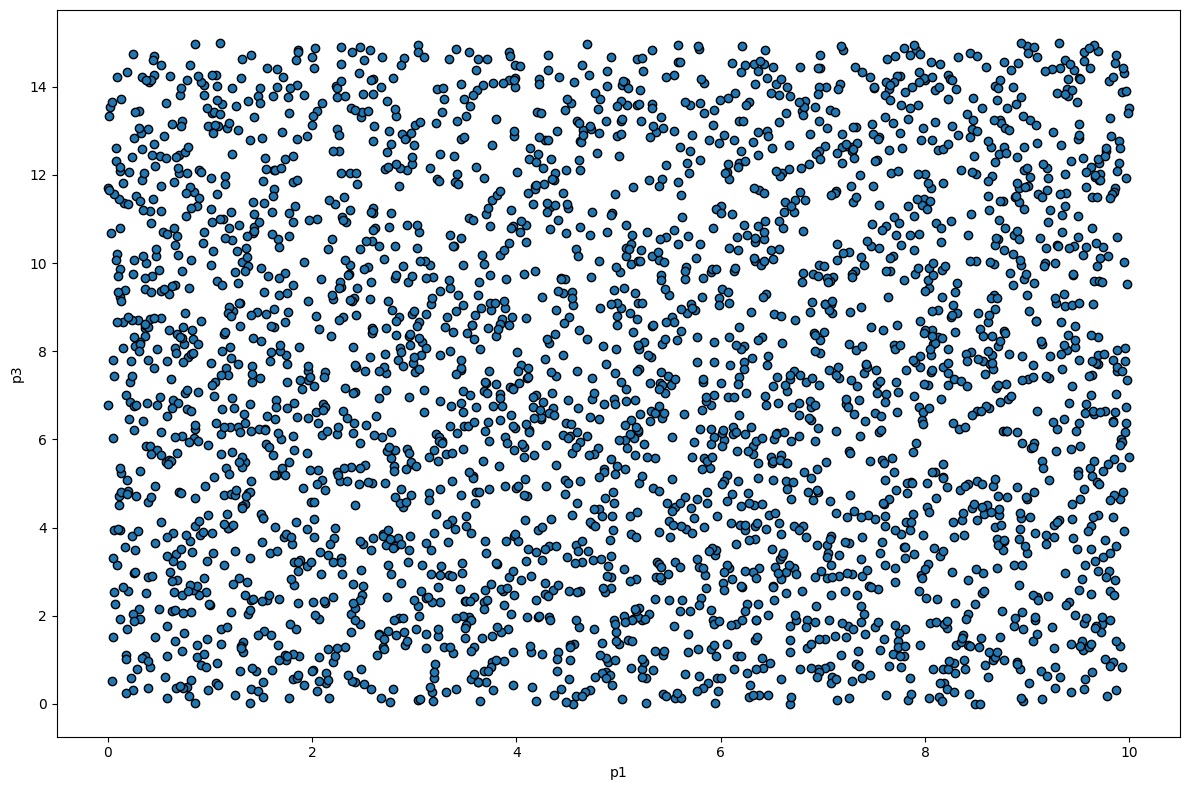

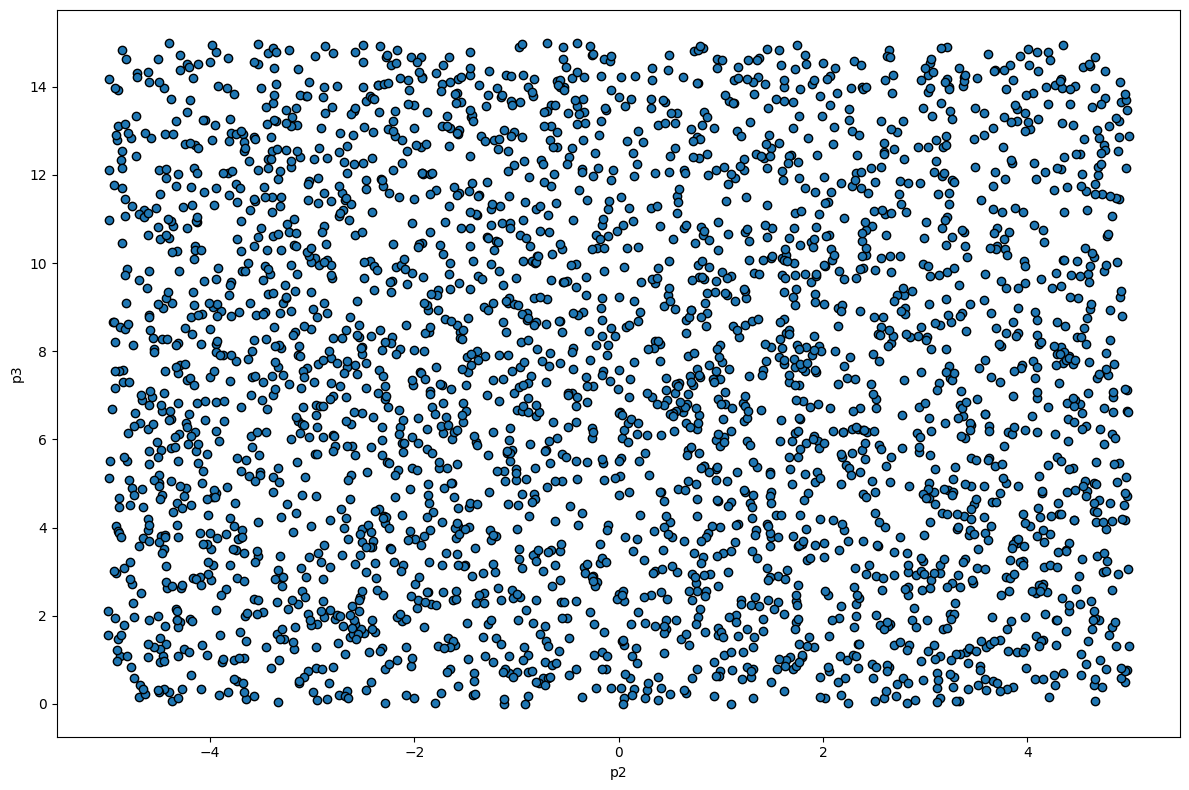

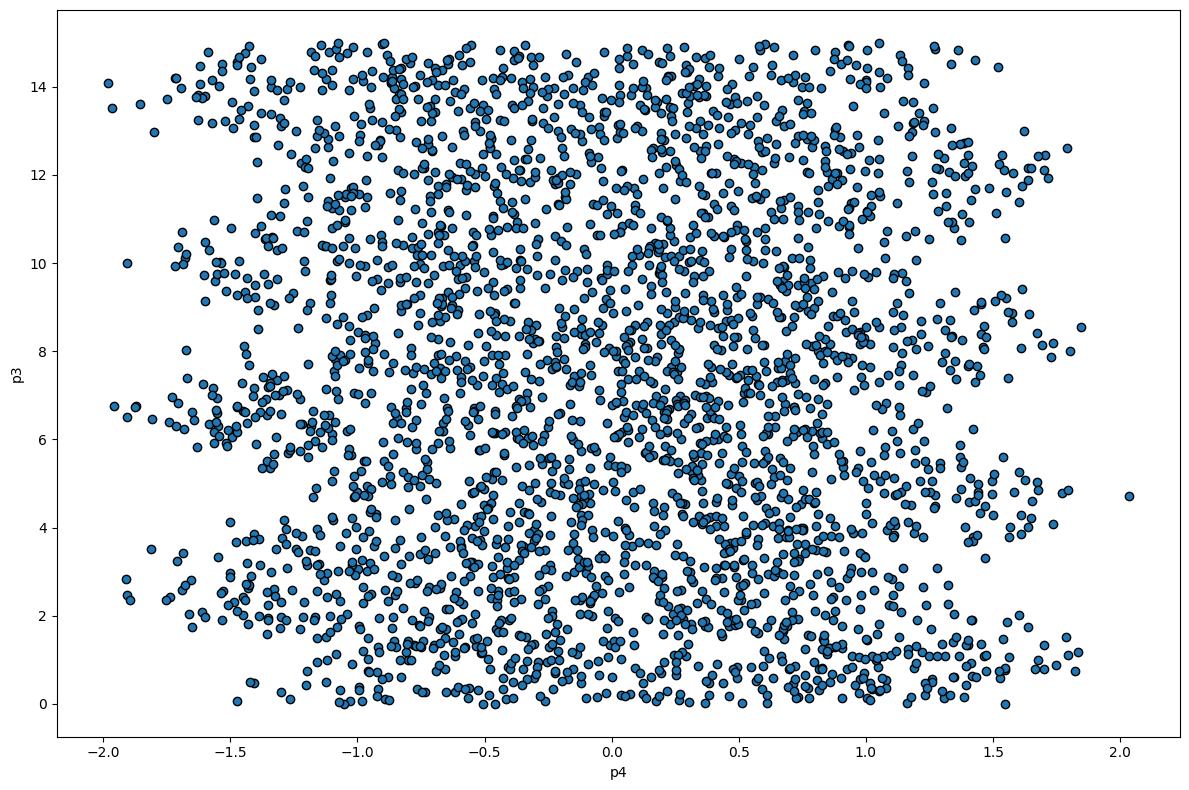

In [5]:
for p in x.columns:
	plt.figure(figsize=(12, 8))
	plt.scatter(df[p], y, ec="k")

	plt.xlabel(f"{p}")
	plt.ylabel("p3")

	plt.tight_layout()
	plt.show()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
	x,
	y,
	test_size=.2,
	random_state=42
)

In [7]:
def f(model, x=np.linspace(0, 14, 100)):
	f_ = 0
	for coef in model.coef_:
		f_ += coef * x
	
	f_ += model.intercept_
	return f_

In [8]:
def f_str(model):
	f_ = "y = "
	for i, coef in enumerate(model.coef_):
		f_ += f"{coef} * k_{i + 1} + "
	
	f_ += f"{model.intercept_}"
	return f_

R2 train SS - 0.0037092294681846383
R2 test SS - 0.0023349172913955663
MAE train SS - 3.6667505356576826
MAE test SS - 3.7442783501552808
MSE train SS - 18.167552146134025
MSE test SS - 18.66141451039847
y = 0.020557509303572294 * k_1 + 0.007164089938616253 * k_2 + -0.2528246118395302 * k_3 + 7.372944001157298


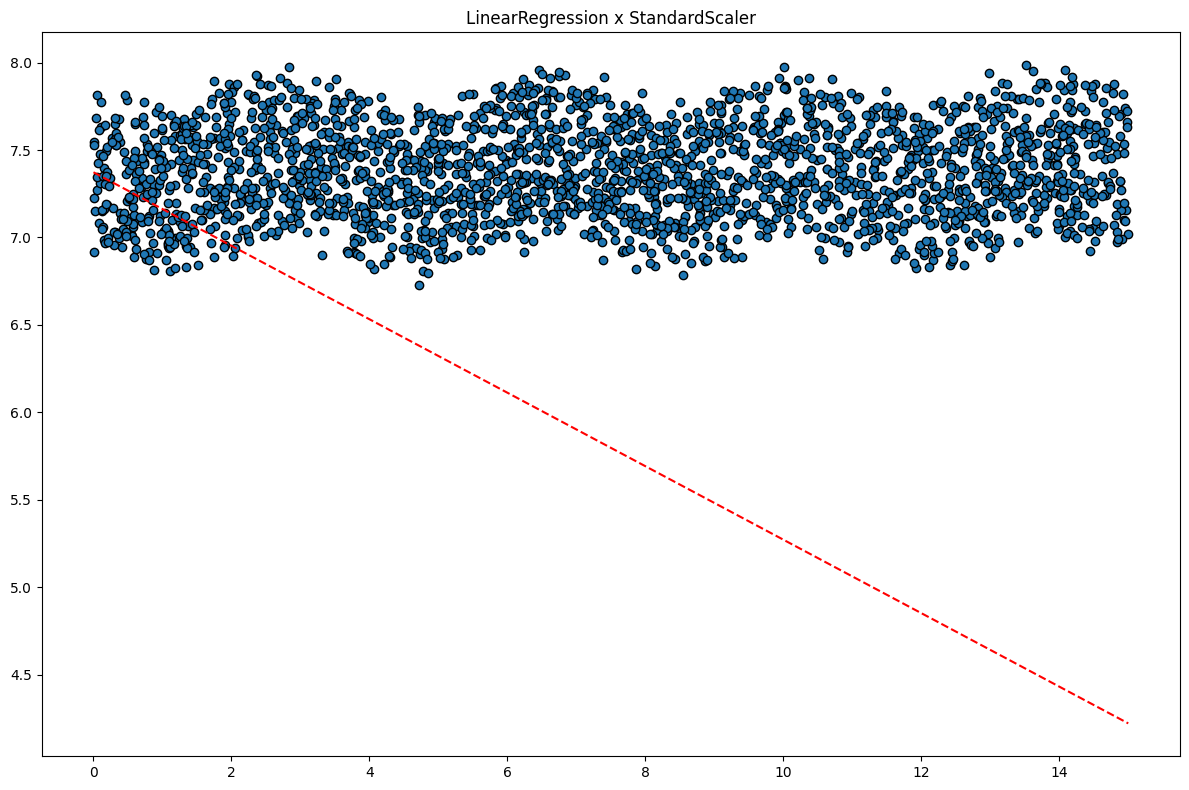

In [9]:
StandardScaler_norm = StandardScaler()
x_train_SS_norm = StandardScaler_norm.fit_transform(x_train)
x_test_SS_norm = StandardScaler_norm.transform(x_test)

LinearRegression_model = LinearRegression().fit(
	x_train_SS_norm,
	y_train
)

y_pred_train_SS_norm = LinearRegression_model.predict(x_train_SS_norm)
y_pred_test_SS_norm = LinearRegression_model.predict(x_test_SS_norm)

print(
	f"R2 train SS - {r2_score(y_train, y_pred_train_SS_norm)}",
	f"R2 test SS - {r2_score(y_test, y_pred_test_SS_norm)}",
	f"MAE train SS - {mean_absolute_error(y_train, y_pred_train_SS_norm)}",
	f"MAE test SS - {mean_absolute_error(y_test, y_pred_test_SS_norm)}",
	f"MSE train SS - {mean_squared_error(y_train, y_pred_train_SS_norm)}",
	f"MSE test SS - {mean_squared_error(y_test, y_pred_test_SS_norm)}",
	f_str(LinearRegression_model),
	sep="\n"
)

plt.figure(figsize=(12, 8))

plt.title("LinearRegression x StandardScaler")
plt.scatter(y_train, y_pred_train_SS_norm, ec="k")
plt.plot(np.linspace(0, 15, 100), f(LinearRegression_model), c="r", ls="--")

plt.tight_layout()
plt.show()

R2 train SS - 0.0037092294681846383
R2 test SS - 0.0023349172913955663
MAE train SS - 3.6667505356576826
MAE test SS - 3.7442783501552808
MSE train SS - 18.167552146134025
MSE test SS - 18.66141451039847
y = 0.07054759508791723 * k_1 + 0.024861807922117007 * k_2 + -1.2170101226212295 * k_3 + 7.921507873010011


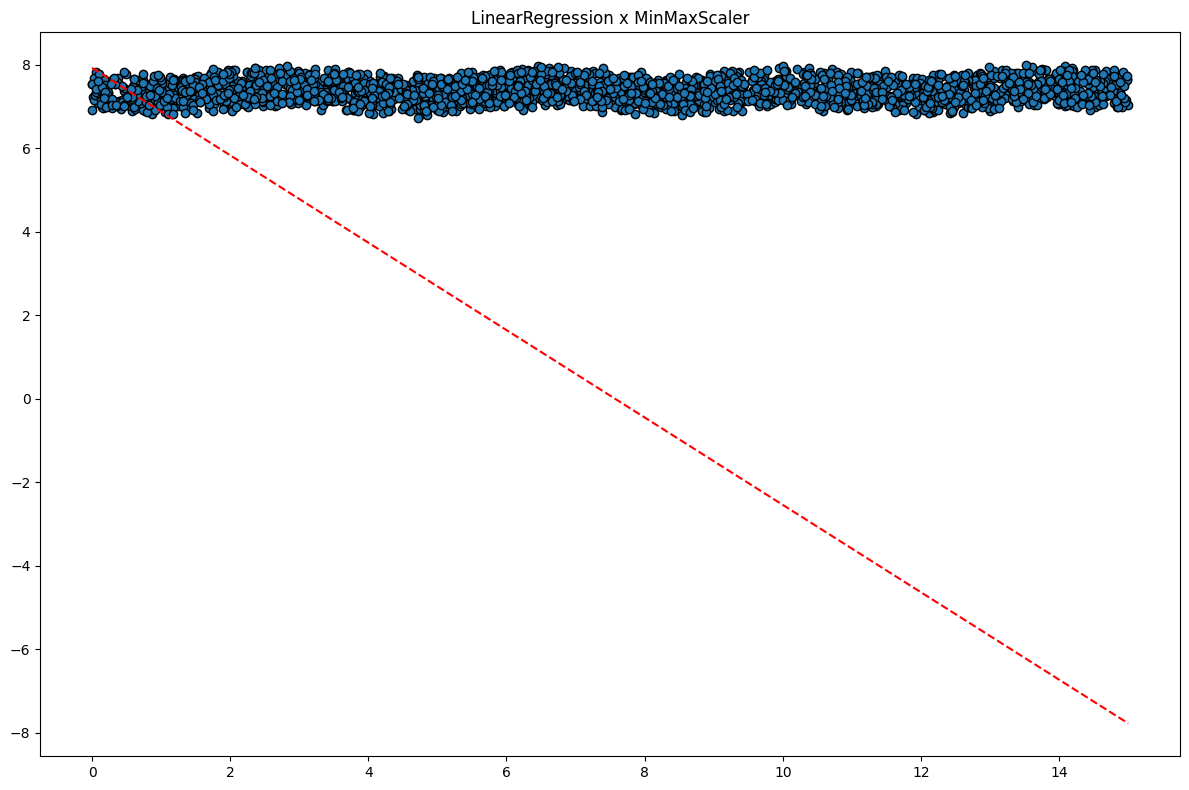

In [10]:
MinMaxScaler_norm = MinMaxScaler()
x_train_MM_norm = MinMaxScaler_norm.fit_transform(x_train)
x_test_MM_norm = MinMaxScaler_norm.transform(x_test)

LinearRegression_model = LinearRegression().fit(
	x_train_MM_norm,
	y_train
)

y_pred_train_MM_norm = LinearRegression_model.predict(x_train_MM_norm)
y_pred_test_MM_norm = LinearRegression_model.predict(x_test_MM_norm)

print(
	f"R2 train SS - {r2_score(y_train, y_pred_train_MM_norm)}",
	f"R2 test SS - {r2_score(y_test, y_pred_test_MM_norm)}",
	f"MAE train SS - {mean_absolute_error(y_train, y_pred_train_MM_norm)}",
	f"MAE test SS - {mean_absolute_error(y_test, y_pred_test_MM_norm)}",
	f"MSE train SS - {mean_squared_error(y_train, y_pred_train_MM_norm)}",
	f"MSE test SS - {mean_squared_error(y_test, y_pred_test_MM_norm)}",
	f_str(LinearRegression_model),
	sep="\n"
)

plt.figure(figsize=(12, 8))

plt.scatter(y_train, y_pred_train_MM_norm, ec="k")
plt.title("LinearRegression x MinMaxScaler")
plt.plot(np.linspace(0, 15, 100), f(LinearRegression_model), c="r", ls="--")

plt.tight_layout()
plt.show()

In [11]:
x_train_LR, x_test_LR, y_train_LR, y_test_LR = train_test_split(
	x,
	(y >= y.median()).astype(int),
	test_size=0.2, 
	random_state=42, 
	stratify=(y >= y.median()).astype(int)
) 

R2 train SS - -2.6170417740506045
R2 test SS - -2.3260549523299208
MAE train SS - 6.924923740668561
MAE test SS - 6.610402690310472
MSE train SS - 65.95744634845137
MSE test SS - 62.21415505620257
y = [ 0.03662172 -0.03033579 -0.02079393] * k_1 + [1.25910187e-06]


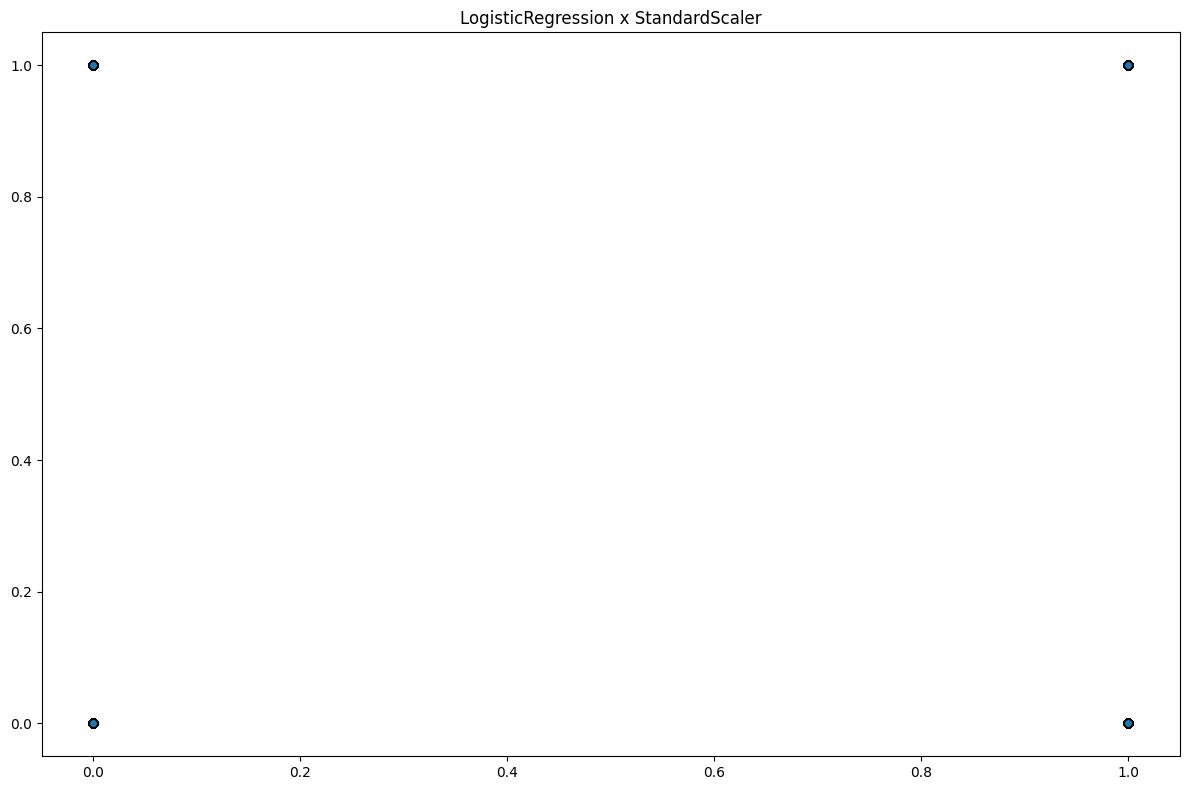

In [12]:
StandardScaler_norm = StandardScaler()
x_train_SS_norm = StandardScaler_norm.fit_transform(x_train_LR)
x_test_SS_norm = StandardScaler_norm.transform(x_test_LR)


LogisticRegression_model = LogisticRegression()
LogisticRegression_model.fit(
	x_train_SS_norm,
	y_train_LR
)

y_pred_train_SS_norm = LogisticRegression_model.predict(x_train_SS_norm)
y_pred_test_SS_norm = LogisticRegression_model.predict(x_test_SS_norm)

print(
	f"R2 train SS - {r2_score(y_train, y_pred_train_SS_norm)}",
	f"R2 test SS - {r2_score(y_test, y_pred_test_SS_norm)}",
	f"MAE train SS - {mean_absolute_error(y_train, y_pred_train_SS_norm)}",
	f"MAE test SS - {mean_absolute_error(y_test, y_pred_test_SS_norm)}",
	f"MSE train SS - {mean_squared_error(y_train, y_pred_train_SS_norm)}",
	f"MSE test SS - {mean_squared_error(y_test, y_pred_test_SS_norm)}",
	f_str(LogisticRegression_model),
	sep="\n"
)

plt.figure(figsize=(12, 8))

plt.scatter(y_train_LR, y_pred_train_SS_norm, ec="k")
plt.title("LogisticRegression x StandardScaler")

plt.tight_layout()
plt.show()

R2 train SS - -2.5903424427020854
R2 test SS - -2.30253905519237
MAE train SS - 6.888714188893204
MAE test SS - 6.582556896383569
MSE train SS - 65.47057895101256
MSE test SS - 61.77428809917095
y = 0.03163183231274686 * k_1 + -0.02622274333784829 * k_2 + -0.02436372966608416 * k_3 + 0.5090455336031141


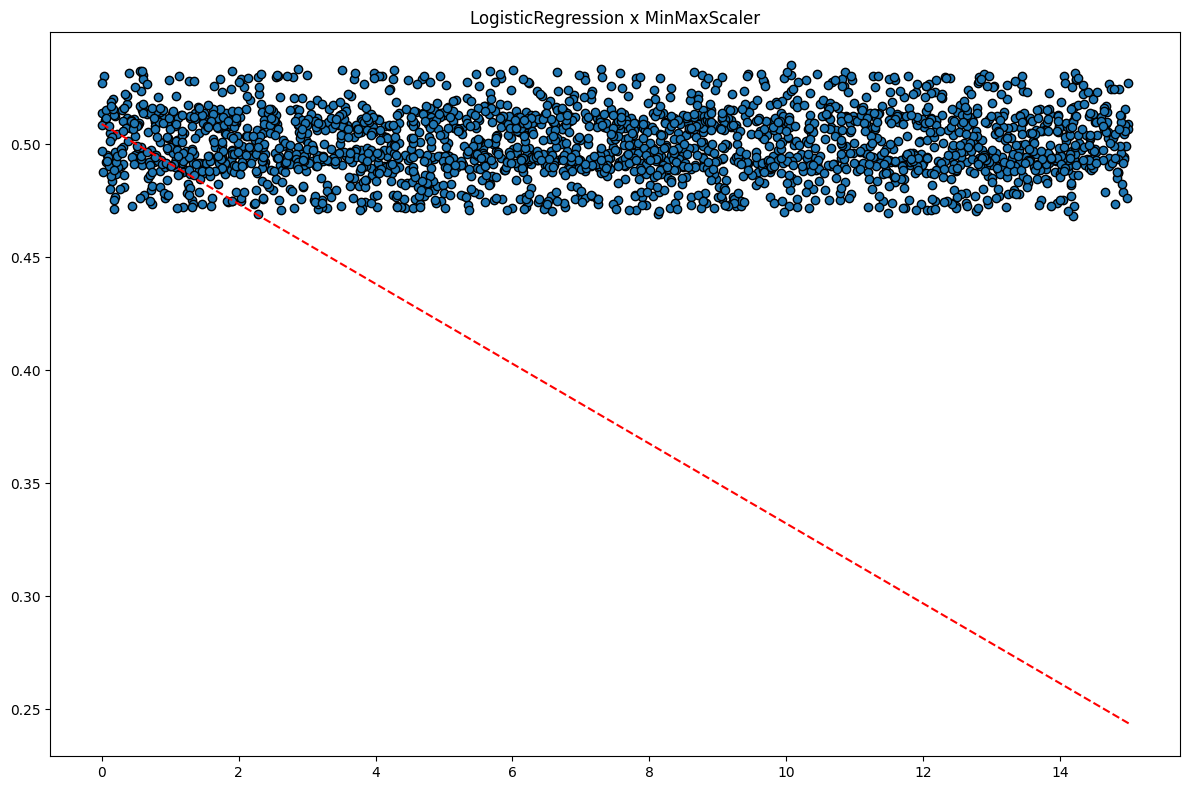

In [13]:
MinMaxScaler_norm = MinMaxScaler()
x_train_MM_norm = MinMaxScaler_norm.fit_transform(x_train_LR)
x_test_MM_norm = MinMaxScaler_norm.transform(x_test_LR)

LogisticRegression_model = LinearRegression().fit(
	x_train_MM_norm,
	y_train_LR
)

y_pred_train_MM_norm = LogisticRegression_model.predict(x_train_MM_norm)
y_pred_test_MM_norm = LogisticRegression_model.predict(x_test_MM_norm)

print(
	f"R2 train SS - {r2_score(y_train, y_pred_train_MM_norm)}",
	f"R2 test SS - {r2_score(y_test, y_pred_test_MM_norm)}",
	f"MAE train SS - {mean_absolute_error(y_train, y_pred_train_MM_norm)}",
	f"MAE test SS - {mean_absolute_error(y_test, y_pred_test_MM_norm)}",
	f"MSE train SS - {mean_squared_error(y_train, y_pred_train_MM_norm)}",
	f"MSE test SS - {mean_squared_error(y_test, y_pred_test_MM_norm)}",
	f_str(LogisticRegression_model),
	sep="\n"
)


plt.figure(figsize=(12, 8))

plt.scatter(y_train, y_pred_train_MM_norm, ec="k")
plt.title("LogisticRegression x MinMaxScaler")
plt.plot(np.linspace(0, 15, 100), f(LogisticRegression_model), c="r", ls="--")

plt.tight_layout()
plt.show()

In [14]:
Lasso_model = Lasso().fit(x_train, y_train)

y_pred_train = Lasso_model.predict(x_train)
y_pred_test = Lasso_model.predict(x_test)

print(
	f"R2 train - {r2_score(y_train, y_pred_train)}",
	f"R2 test - {r2_score(y_test, y_pred_test)}",
	f"MAE train - {mean_absolute_error(y_train, y_pred_train)}",
	f"MAE test - {mean_absolute_error(y_test, y_pred_test)}",
	f"MSE train - {mean_squared_error(y_train, y_pred_train)}",
	f"MSE test - {mean_squared_error(y_test, y_pred_test)}",
	f_str(Lasso_model),
	sep="\n"
)

R2 train - 0.0
R2 test - -0.005148128048743317
MAE train - 3.6660478198761637
MAE test - 3.7501806426465754
MSE train - 18.23519065266084
MSE test - 18.801385542073056
y = 0.0 * k_1 + -0.0 * k_2 + -0.0 * k_3 + 7.372944001157298


In [15]:
for solver in ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga", "lbfgs"]:
	Ridge_model = Ridge(
        solver=solver,
        positive=True if solver in ["auto", "lbfgs"] else False
    ).fit(x_train, y_train)

	y_pred_train = Lasso_model.predict(x_train)
	y_pred_test = Lasso_model.predict(x_test)

	print(
		f"R2 train - {r2_score(y_train, y_pred_train)}",
		f"R2 test - {r2_score(y_test, y_pred_test)}",
		f"MAE train - {mean_absolute_error(y_train, y_pred_train)}",
		f"MAE test - {mean_absolute_error(y_test, y_pred_test)}",
		f"MSE train - {mean_squared_error(y_train, y_pred_train)}",
		f"MSE test - {mean_squared_error(y_test, y_pred_test)}",
		f_str(Ridge_model),
		sep="\n"
	)
	print("-" * 100)

R2 train - 0.0
R2 test - -0.005148128048743317
MAE train - 3.6660478198761637
MAE test - 3.7501806426465754
MSE train - 18.23519065266084
MSE test - 18.801385542073056
y = 0.03743895288045229 * k_1 + 0.0 * k_2 + 0.0 * k_3 + 7.18566441204593
----------------------------------------------------------------------------------------------------
R2 train - 0.0
R2 test - -0.005148128048743317
MAE train - 3.6660478198761637
MAE test - 3.7501806426465754
MSE train - 18.23519065266084
MSE test - 18.801385542073056
y = 0.007077418698030143 * k_1 + 0.002482261463236661 * k_2 + -0.3028387149841923 * k_3 + 7.333465491144417
----------------------------------------------------------------------------------------------------
R2 train - 0.0
R2 test - -0.005148128048743317
MAE train - 3.6660478198761637
MAE test - 3.7501806426465754
MSE train - 18.23519065266084
MSE test - 18.801385542073056
y = 0.007077418698030133 * k_1 + 0.0024822614632367514 * k_2 + -0.3028387149841924 * k_3 + 7.333465491144417
----